In [ ]:
import os
from os import listdir
from os import path
from os.path import isfile, join, getsize
import re
import pandas as pd

import json
import io
import glob

#need this for some stupid reason to import essentia
import sys
sys.path.append("/usr/local/lib/python3.8/site-packages")
import essentia
import essentia.standard as es

from essentia.pytools.spectral import hpcpgram
%matplotlib inline
import matplotlib.pyplot as plt

In [170]:
ext_drive_dir = '/volumes/CCV_SSD_1/'
working_root_dir = 'similar_songs/'
png_folder = 'png_output/'
harmonic_pitch_class_profile = 'harmonic_pitch_class_profile/'
cover_song_simularity = 'cover_song_simularity/'
cross_recurrent_plot = 'cross_recurrent_plot/'

audio_stems = 'audio_output_stems/'

os.chdir(ext_drive_dir+working_root_dir)


In [83]:
def calculate_similarity(file1, file2):
    song_1 = es.MonoLoader(filename=file1, sampleRate=32000)()
    song_2 = es.MonoLoader(filename=file2, sampleRate=32000)()

    #calculate HPCP
    song_1_hpcp = hpcpgram(song_1, sampleRate=32000)
    song_2_hpcp = hpcpgram(song_2, sampleRate=32000)

    #plot HPCP
    fig = plt.gcf()
    fig.set_size_inches(14.5, 4.5)

    plt.title("Song 1 HPCP: " + file1)
    plt.imshow(song_1_hpcp[:500].T, aspect='auto', origin='lower', interpolation='none')
    plt.savefig(ext_drive_dir + 
                working_root_dir + 
                png_folder + 
                harmonic_pitch_class_profile +
                file1+'_hpcp.png')
    
    plt.title("Song 2 HPCP: " + file1)
    plt.imshow(song_2_hpcp[:500].T, aspect='auto', origin='lower', interpolation='none')
    plt.savefig(ext_drive_dir + 
                working_root_dir + 
                png_folder + 
                harmonic_pitch_class_profile +
                file2+'_hpcp.png')
    
    #Calculate ChromaCrossSimularity
    crp = es.ChromaCrossSimilarity(frameStackSize=9, 
                                 frameStackStride=1, 
                                 binarizePercentile=0.095,
                                 oti=True)

    true_pair_crp = crp(song_1_hpcp, song_2_hpcp)
    
    #plot CRP
    fig = plt.gcf()
    fig.set_size_inches(15.5, 5.5)

    plt.title('Cross Recurrent Plot')
    plt.xlabel(file1)
    plt.ylabel(file2)
    plt.imshow(true_pair_crp, origin='lower')
    plt.savefig(ext_drive_dir + 
                working_root_dir + 
                png_folder + 
                cross_recurrent_plot +
                file1+'_'+file2+'_crp.png')
    
    #Calculate Distance with CSS
    score_matrix, distance = es.CoverSongSimilarity(disOnset=0.5, 
                                                  disExtension=0.5, 
                                                  alignmentType='chen17',
                                                  distanceType='asymmetric')(true_pair_crp)

    fig = plt.gcf()
    fig.set_size_inches(15.5, 5.5)

    plt.title('Song similarity distance: %s' % distance)
    plt.xlabel(file1)
    plt.ylabel(file2)
    plt.imshow(score_matrix, origin='lower')
    plt.savefig(ext_drive_dir + 
                working_root_dir + 
                png_folder + 
                cover_song_simularity +
                file1+'_'+file2+'_css.png')
    
    return distance

In [171]:
filename_list1 = []
filestem_list1 = []
result = pd.DataFrame({'pair':[], 
                       'song_1':[],
                       'song_2':[],
                       'distance':[], 
                       'song_1_distance_to_baseline':[],
                       'song_2_distance_to_baseline':[]})

#look for mp3 and wav.
#the wav file here is the baseline... a guassian whitenoise at 0db

types = ('*.mp3', '*.wav')
#find all file pairs
for f in types:
    filename_list1.extend(glob.glob(f))
    
#split the filenames
for f in filename_list1:
    filestem = f.split('.')
    filestem_list1.append([filestem[0],filestem[1],filestem[2]])

filestem_list2 = filestem_list1



In [172]:
#find baseline song at index 0
baseline_song_name = ''
for num0, x in enumerate(filestem_list1):
    if x[0] == str(0):
        baseline_song_name = x[0]+'.'+x[1]+'.'+x[2]

baseline_song_name

'0.guassian-whitenoise-0db.wav'

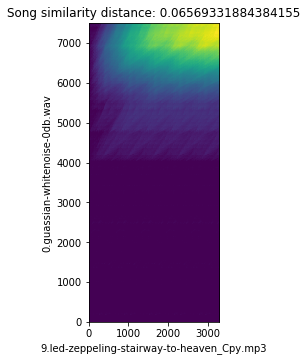

In [86]:
for num1, i in enumerate(filestem_list1):
    for num2, j in enumerate(filestem_list2):
        if i[0] == j[0] and i[1] != j[1]:
            #find distance and aggregate 
            #find distance against baseline song and aggregate
            filename1 = i[0] + '.' + i[1] + '.' + i[2]
            filename2 = j[0] + '.' + j[1] + '.' + j[2]
            distance = calculate_similarity(filename1, filename2)
            baseline_distance1 = calculate_similarity(filename1, baseline_song_name)
            baseline_distance2 = calculate_similarity(filename2, baseline_song_name)
            new_row = {'pair':i[0],
                       'song_1': filename1,
                       'song_2': filename2,
                       'distance':distance, 
                       'song_1_distance_to_baseline':baseline_distance1,
                       'song_2_distance_to_baseline':baseline_distance2,}
            result = result.append(new_row, ignore_index=True)
            
            filestem_list2.pop(num2)

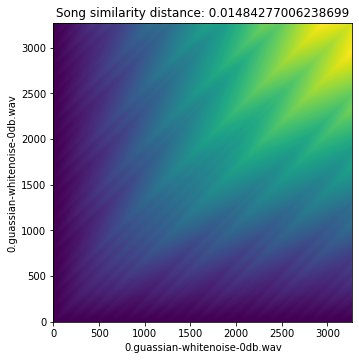

In [88]:
#add in a whitenoise to whitenoise compare for ground truth
distance = calculate_similarity(baseline_song_name, baseline_song_name)
baseline_distance1 = calculate_similarity(baseline_song_name, baseline_song_name)
baseline_distance2 = calculate_similarity(baseline_song_name, baseline_song_name)
new_row = {'pair':'0',
           'song_1': filename1,
           'song_2': filename2,
           'distance':distance, 
           'song_1_distance_to_baseline':baseline_distance1,
           'song_2_distance_to_baseline':baseline_distance2,}

result = result.append(new_row, ignore_index=True)

In [89]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
result

,pair,song_1,song_2,distance,song_1_distance_to_baseline,song_2_distance_to_baseline
0,1,1.Juice WRLD - Lucid Dreams_Cpy.mp3,1.yellowcard-holly-wood-died_Org.mp3,0.049629,0.110355,0.085593
1,10,10.bruno-mars-uptown-funk_Cpy.mp3,10.the-gap-band-oops-up-side-your-head_Org.mp3,0.043613,0.097727,0.102543
2,11,11.drake-who-do-you-love-feat_Cpy.mp3,11.rappin-4-tay-playaz-club_Org.mp3,0.044297,0.101904,0.065693
3,12,12.the-doors-hello-i-love-you_Cpy.mp3,12.the-kinks-all-day-and-all-of-the-night_Org.mp3,0.052039,0.179089,0.133533
4,13,13.marvin-gaye-got-to-give-it-up_Org.mp3,13.robin-thick-blurred-lines_Cpy.mp3,inf,inf,0.117734
5,14,14.breakbot-baby-i-m-yours_Org.mp3,14.bruno-mars-treasure_Cpy.mp3,0.037541,0.103846,0.156336
6,15,15.jake-holmes-dazed-and-confused_Org.mp3,15.led-zeppelin-1969-i-dazed-and-confused_Cpy.mp3,0.050295,0.181072,0.074698
7,16,16.calvin-harris-calvin-harris-im-not-alone_Or...,16.chris-brown-yeah-3x_Cpy.mp3,inf,0.129748,inf
8,17,17.guns-n-39-roses-riad-n-39-the-bedouins_Cpy.mp3,17.ulrich-schnauss-wherever-you-are_Org.mp3,0.072692,0.089057,0.080989
9,18,18.coldplay-viva-la-vida_Cpy.mp3,18.joe-satriani-if-i-could-fly_Org.mp3,0.055675,0.121355,0.095285


In [90]:
result.to_csv('../song_pair_similarity.csv', index = False)

In [180]:
def calculate_similarity_stems(file1, file2):
    song_1 = es.MonoLoader(filename=audio_stems+file1, sampleRate=32000)()
    song_2 = es.MonoLoader(filename=audio_stems+file2, sampleRate=32000)()


    #calculate HPCP
    song_1_hpcp = hpcpgram(song_1, sampleRate=32000)
    song_2_hpcp = hpcpgram(song_2, sampleRate=32000)

    #plot HPCP
    fig = plt.gcf()
    fig.set_size_inches(14.5, 4.5)

    plt.title("Song 1 HPCP: " + file1)
    plt.imshow(song_1_hpcp[:500].T, aspect='auto', origin='lower', interpolation='none')
    plt.savefig(ext_drive_dir + 
                working_root_dir + 
                png_folder + 
                harmonic_pitch_class_profile +
                file1.replace("/", "_")+'_hpcp.png')

    plt.title("Song 2 HPCP: " + file1)
    plt.imshow(song_2_hpcp[:500].T, aspect='auto', origin='lower', interpolation='none')
    plt.savefig(ext_drive_dir + 
                working_root_dir + 
                png_folder + 
                harmonic_pitch_class_profile +
                file2.replace("/", "_")+'_hpcp.png')

    #Calculate ChromaCrossSimularity
    crp = es.ChromaCrossSimilarity(frameStackSize=9, 
                                 frameStackStride=1, 
                                 binarizePercentile=0.095,
                                 oti=True)

    true_pair_crp = crp(song_1_hpcp, song_2_hpcp)

    #plot CRP
    fig = plt.gcf()
    fig.set_size_inches(15.5, 5.5)

    plt.title('Cross Recurrent Plot')
    plt.xlabel(file1)
    plt.ylabel(file2)
    plt.imshow(true_pair_crp, origin='lower')
    plt.savefig(ext_drive_dir + 
                working_root_dir + 
                png_folder + 
                cross_recurrent_plot +
                file1.replace("/", "_")+'_'+file2.replace("/", "_")+'_crp.png')

    #Calculate Distance with CSS
    score_matrix, distance = es.CoverSongSimilarity(disOnset=0.5, 
                                                  disExtension=0.5, 
                                                  alignmentType='chen17',
                                                  distanceType='asymmetric')(true_pair_crp)

    fig = plt.gcf()
    fig.set_size_inches(15.5, 5.5)

    plt.title('Song similarity distance: %s' % distance)
    plt.xlabel(file1)
    plt.ylabel(file2)
    plt.imshow(score_matrix, origin='lower')
    plt.savefig(ext_drive_dir + 
                working_root_dir + 
                png_folder + 
                cover_song_simularity +
                file1.replace("/", "_")+'_'+file2.replace("/", "_")+'_css.png')

    return distance

In [181]:
#get all the directories for the stems
directories = []
for x in os.walk(ext_drive_dir+working_root_dir+audio_stems):
    directories.append(x[1])

directories = directories[0]

directories

['0.guassian-whitenoise-0db',
 '1.Juice WRLD - Lucid Dreams_Cpy',
 '1.yellowcard-holly-wood-died_Org',
 '10.bruno-mars-uptown-funk_Cpy',
 '10.the-gap-band-oops-up-side-your-head_Org',
 '11.drake-who-do-you-love-feat_Cpy',
 '11.rappin-4-tay-playaz-club_Org',
 '12.the-doors-hello-i-love-you_Cpy',
 '12.the-kinks-all-day-and-all-of-the-night_Org',
 '13.marvin-gaye-got-to-give-it-up_Org',
 '13.robin-thick-blurred-lines_Cpy',
 '14.breakbot-baby-i-m-yours_Org',
 '14.bruno-mars-treasure_Cpy',
 '15.jake-holmes-dazed-and-confused_Org',
 '15.led-zeppelin-1969-i-dazed-and-confused_Cpy',
 '16.calvin-harris-calvin-harris-im-not-alone_Org',
 '16.chris-brown-yeah-3x_Cpy',
 '17.guns-n-39-roses-riad-n-39-the-bedouins_Cpy',
 '17.ulrich-schnauss-wherever-you-are_Org',
 '18.coldplay-viva-la-vida_Cpy',
 '18.joe-satriani-if-i-could-fly_Org',
 '19.adam-freeland-mancry_Org',
 '19.the-black-eyed-peas-party-all-the-time_Cpy',
 '2.lana-del-rey-get-free_Cpy',
 '2.radioheard-creep_Org',
 '20.avril-lavin-girlfriend_

In [182]:
#traverse each directory and calculate distance pairs
#this time for each stem type
filename_list1 = []
filestem_list2 = []
result_stems = pd.DataFrame({'pair':[], 
                             'song_1':[],
                             'song_2':[],
                             'distance_argmin':[],
                             'distance_bass':[], 
                             'distance_drums':[],
                             'distance_vocals':[],
                             'distance_other':[],
                             'song_1_distance_to_baseline_bass':[],
                             'song_1_distance_to_baseline_drums':[],
                             'song_1_distance_to_baseline_vocals':[],
                             'song_1_distance_to_baseline_other':[],
                             'song_2_distance_to_baseline_bass':[],
                             'song_2_distance_to_baseline_drums':[],
                             'song_2_distance_to_baseline_vocals':[],
                             'song_2_distance_to_baseline_other':[],})

#set file names since they are all the same
bass = 'bass.wav'
drums = 'drums.wav'
voice = 'vocals.wav'
other = 'other.wav'

stems = (bass, drums, voice, other)

#reset the lists to keep track

types = ('*.mp3', '*.wav')
#find all file pairs
for f in types:
    filename_list1.extend(glob.glob(f))
    
#split the filenames
for f in filename_list1:
    filestem = f.split('.')
    filestem_list1.append([filestem[0],filestem[1],filestem[2]])

filestem_list2 = filestem_list1



In [183]:
#find baseline song at index 0
baseline_song_name = ''
for num0, x in enumerate(filestem_list1):
    if x[0] == str(0):
        baseline_song_name = x[0]+'.'+x[1]+'.'+x[2]

baseline_song_name

'0.guassian-whitenoise-0db.wav'

In [184]:
for f in stems:
    print(f)

bass.wav
drums.wav
vocals.wav
other.wav


In [ ]:
baseline_song_name = x[0]+'.'+x[1]

for num1, i in enumerate(filestem_list1):
    for num2, j in enumerate(filestem_list2):
        if i[0] == j[0] and i[1] != j[1]:
            #find distance and aggregate 
            #find distance against baseline song and aggregate
            dir0 = baseline_song_name
            dir1 = i[0] + '.' + i[1]
            dir2 = j[0] + '.' + j[1]
            
            argmin = 0
            distance_bass = 0
            distance_drums = 0
            distance_voice = 0
            distance_other = 0
            
            for f in stems:
                filename0 = dir0 + '/' + f
                filename1 = dir1 + '/' + f 
                filename2 = dir2 + '/' + f
                
                distance = calculate_similarity_stems(filename1, filename2)
                baseline_distance1 = calculate_similarity_stems(filename1, filename0)
                baseline_distance2 = calculate_similarity_stems(filename2, filename0)
                
                if f == 'bass.wav':
                    distance_bass = distance
                    song_1_distance_to_baseline_bass = baseline_distance1
                    song_2_distance_to_baseline_bass = baseline_distance2
                    
                elif f == 'drums.wav':
                    distance_drums = distance
                    song_1_distance_to_baseline_drums = baseline_distance1
                    song_2_distance_to_baseline_drums = baseline_distance2
                    
                elif f == 'vocals.wav':
                    distance_vocals = distance
                    song_1_distance_to_baseline_vocals = baseline_distance1
                    song_2_distance_to_baseline_vocals = baseline_distance2
                
                else:
                    distance_other = distance
                    song_1_distance_to_baseline_other = baseline_distance1
                    song_2_distance_to_baseline_other = baseline_distance2
            
            
            argset = set([distance_bass,
                       distance_drums,
                       distance_vocals,
                       distance_other])
        
            argmin = min(argset)
                
            new_row = {'pair':i[0], 
                         'song_1':i[0] + '.' + i[1],
                         'song_2':j[0] + '.' + j[1],
                         'distance_argmin':argmin,
                         'distance_bass':distance_bass, 
                         'distance_drums':distance_drums,
                         'distance_vocals':distance_vocals,
                         'distance_other':distance_other,
                         'song_1_distance_to_baseline_bass':song_1_distance_to_baseline_bass,
                         'song_1_distance_to_baseline_drums':song_1_distance_to_baseline_drums,
                         'song_1_distance_to_baseline_vocals':song_1_distance_to_baseline_vocals,
                         'song_1_distance_to_baseline_other':song_1_distance_to_baseline_other,
                         'song_2_distance_to_baseline_bass':song_2_distance_to_baseline_bass,
                         'song_2_distance_to_baseline_drums':song_2_distance_to_baseline_drums,
                         'song_2_distance_to_baseline_vocals':song_2_distance_to_baseline_vocals,
                         'song_2_distance_to_baseline_other':song_2_distance_to_baseline_other,}

            result_stems = result_stems.append(new_row, ignore_index=True)
            print(new_row)
            filestem_list2.pop(num2)

{'pair': '1', 'song_1': '1.Juice WRLD - Lucid Dreams_Cpy', 'song_2': '1.yellowcard-holly-wood-died_Org', 'distance_argmin': 0.037106920033693314, 'distance_bass': 0.051645293831825256, 'distance_drums': 0.037106920033693314, 'distance_vocals': 0.05059776082634926, 'distance_other': 0.05083119869232178, 'song_1_distance_to_baseline_bass': 0.02713724412024021, 'song_1_distance_to_baseline_drums': 0.04461510851979256, 'song_1_distance_to_baseline_vocals': 0.04302171245217323, 'song_1_distance_to_baseline_other': 0.09681705385446548, 'song_2_distance_to_baseline_bass': 0.056905895471572876, 'song_2_distance_to_baseline_drums': 0.04458034783601761, 'song_2_distance_to_baseline_vocals': 0.05853593721985817, 'song_2_distance_to_baseline_other': 0.09848343580961227}
{'pair': '10', 'song_1': '10.bruno-mars-uptown-funk_Cpy', 'song_2': '10.the-gap-band-oops-up-side-your-head_Org', 'distance_argmin': 0.03594103828072548, 'distance_bass': 0.050507377833127975, 'distance_drums': 0.03594103828072548,

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
result_stems

In [ ]:
result_stems.to_csv('/volumes/CCV_SSD_1/similar_songs/stem_pair_similarity.csv', index = False)